In [1]:
import torch
import torch.nn as nn
import scanpy as sc
import numpy as np

import slalom as sl
import h5py

In [2]:
adata = sc.read('mouse_retina_sbs.h5ad')

In [3]:
select_genes = adata.varm['I'].sum(1)>0
adata._inplace_subset_var(select_genes)
adata.X-=adata.X.mean(0)

In [4]:
class ProxOperGroupL2:
    def __init__(self, alpha, omega, inplace=True):
    # omega - vector of coefficients with size
    # equal to the number of groups
        self._group_vect = omega*alpha
        self._inplace = inplace
    
    def __call__(self, W):        
        if not self._inplace:
            W = W.clone()
        
        norm_vect = W.norm(p=2, dim=0)
        norm_g_gr_vect = norm_vect>self._group_vect
        
        scaled_norm_vector = norm_vect/self._group_vect.view(-1)
        scaled_norm_vector+=(~(scaled_norm_vector>0)).float()
        
        W-=W/scaled_norm_vector
        W*=norm_g_gr_vect.float()
        
        return W

In [5]:
class ProxOperL1:
    def __init__(self, alpha, I, inplace=True):
        self._alpha=alpha
        self._I = ~I.bool()
        self._inplace=inplace
    
    def __call__(self, W):
        if not self._inplace:
            W = W.clone()
        
        W_geq_alpha = W>=self._alpha
        W_leq_neg_alpha = W<=-self._alpha
        
        W-=(W_geq_alpha&self._I).float()*self._alpha
        W+=(W_leq_neg_alpha&self._I).float()*self._alpha
        W-=(~W_geq_alpha&~W_leq_neg_alpha&self._I).float()*W
               
        return W

In [6]:
class AutoencoderLinearDecoder(nn.Module):
    def __init__(self, n_vars, n_terms, **kwargs):
        super().__init__()
        
        self.n_vars = n_vars
        self.n_terms = n_terms
        self.dropout_rate = kwargs.get("dropout_rate", 0.2)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.n_vars, 400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(400, self.n_terms)
        )
        
        self.decoder = nn.Linear(self.n_terms, self.n_vars, bias=False)
        
        self.decoder.weight.data.normal_()
        self.decoder.weight.data/=self.n_terms**0.5
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded      

In [7]:
def train_autoencoder(adata, autoencoder, l2_reg_alpha, lr, batch_size, num_epochs, prox_operator):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr)
    
    t_X = torch.from_numpy(adata.X)
    n_obs = adata.n_obs
    
    zeros = torch.zeros((batch_size, autoencoder.n_terms))
    
    l2_loss = nn.MSELoss(reduction='sum')
    
    for epoch in range(num_epochs):
        autoencoder.train()
        
        for step in range(int(adata.n_obs/batch_size)):
            X = torch.from_numpy(adata.chunk_X(batch_size))
            
            encoded, decoded = autoencoder(X)
            
            loss = (l2_loss(decoded, X)+l2_reg_alpha*l2_loss(encoded, zeros))/batch_size
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            prox_operator(autoencoder.decoder.weight.data)
            
            if step % 100 == 0: 
                print('Epoch:', epoch, '| batch train loss: %.4f' % loss.data.numpy())
                
        #prox_operator(autoencoder.decoder.weight.data)
        
        autoencoder.eval()
        t_encoded, t_decoded = autoencoder(t_X)
        
        t_reconst = l2_loss(t_decoded, t_X).data.numpy()/n_obs
        t_regul = l2_reg_alpha*l2_loss(t_encoded, torch.zeros_like(t_encoded)).data.numpy()/n_obs
        t_loss = t_reconst + l2_reg_alpha*t_regul
        
        print('Epoch:', epoch, '-- total train loss: %.4f=%.4f+%.4f' % (t_loss, t_reconst, t_regul))
        
        n_deact_terms = (~(autoencoder.decoder.weight.data.norm(p=2, dim=0)>0)).float().sum().numpy()
        print('Number of deactivated terms:', int(n_deact_terms))
        
        n_deact_genes = (~(autoencoder.decoder.weight.data>0)).float().sum().numpy()
        print('Number of deactivated genes:', int(n_deact_genes))

In [190]:
autoencoder = AutoencoderLinearDecoder(adata.n_vars, len(adata.uns['terms']))

In [191]:
LR = 0.001
BATCH_SIZE = 62
N_EPOCHS = 60

ALPHA0 = 0.1

ALPHA1 = 0.93*LR #0.36 #0.4 #0.45 #0.95
ALPHA2 = 0.57*LR #0.78 #0.74 #0.71 #0.55
I = torch.from_numpy(adata.varm['I'])
#OMEGA = I.sum(0).float().sqrt()
OMEGA = torch.ones(len(adata.uns['terms']))

In [192]:
prox_op_l1 = ProxOperL1(ALPHA1, I)
prox_op_group = ProxOperGroupL2(ALPHA2, OMEGA)

prox_operator = lambda W: prox_op_group(prox_op_l1(W))

In [193]:
train_autoencoder(adata, autoencoder, ALPHA0, LR, BATCH_SIZE, N_EPOCHS, prox_operator)

Epoch: 0 | batch train loss: 421.2986
Epoch: 0 | batch train loss: 159.6880
Epoch: 0 | batch train loss: 145.1997
Epoch: 0 -- total train loss: 143.0384=142.4627+5.7571
Number of deactivated terms: 0
Number of deactivated genes: 127082
Epoch: 1 | batch train loss: 154.3025
Epoch: 1 | batch train loss: 141.3422
Epoch: 1 | batch train loss: 148.4465
Epoch: 1 -- total train loss: 127.4816=126.7140+7.6764
Number of deactivated terms: 1
Number of deactivated genes: 128386
Epoch: 2 | batch train loss: 139.4729
Epoch: 2 | batch train loss: 130.0075
Epoch: 2 | batch train loss: 136.8719
Epoch: 2 -- total train loss: 117.7103=116.9242+7.8611
Number of deactivated terms: 4
Number of deactivated genes: 128691
Epoch: 3 | batch train loss: 138.0326
Epoch: 3 | batch train loss: 127.8501
Epoch: 3 | batch train loss: 136.7544
Epoch: 3 -- total train loss: 112.2386=111.5033+7.3535
Number of deactivated terms: 7
Number of deactivated genes: 129113
Epoch: 4 | batch train loss: 124.4091
Epoch: 4 | batch t

Epoch: 34 -- total train loss: 96.8074=96.3764+4.3096
Number of deactivated terms: 23
Number of deactivated genes: 129238
Epoch: 35 | batch train loss: 105.9368
Epoch: 35 | batch train loss: 111.7603
Epoch: 35 | batch train loss: 118.5875
Epoch: 35 -- total train loss: 96.7462=96.3115+4.3467
Number of deactivated terms: 23
Number of deactivated genes: 129315
Epoch: 36 | batch train loss: 112.1728
Epoch: 36 | batch train loss: 106.3291
Epoch: 36 | batch train loss: 112.8632
Epoch: 36 -- total train loss: 96.5969=96.1573+4.3956
Number of deactivated terms: 23
Number of deactivated genes: 129402
Epoch: 37 | batch train loss: 108.7794
Epoch: 37 | batch train loss: 112.3865
Epoch: 37 | batch train loss: 109.4445
Epoch: 37 -- total train loss: 96.6480=96.2143+4.3366
Number of deactivated terms: 23
Number of deactivated genes: 129377
Epoch: 38 | batch train loss: 106.6798
Epoch: 38 | batch train loss: 103.2384
Epoch: 38 | batch train loss: 113.0894
Epoch: 38 -- total train loss: 96.8059=96.37

In [194]:
autoencoder.decoder.weight.data.norm(p=2, dim=0)

tensor([0.0000, 0.9933, 0.8532, 1.1627, 0.0000, 1.2789, 1.0267, 0.6930, 1.3733,
        1.1018, 0.0000, 1.5263, 0.8128, 1.2572, 0.2159, 0.7611, 0.0000, 1.2221,
        0.9532, 0.0000, 0.9386, 0.9134, 1.0268, 1.4903, 1.3378, 0.9313, 1.3872,
        1.2517, 1.0693, 0.9556, 1.3116, 1.3135, 0.8602, 1.3037, 0.6239, 1.1161,
        0.0000, 1.3875, 1.4008, 1.2231, 1.1383, 1.1607, 0.0000, 1.4309, 0.0000,
        0.7370, 1.4936, 1.5459, 1.5069, 1.5016, 1.1006, 0.9319, 0.7681, 1.1361,
        1.3141, 1.3558, 1.0612, 1.1403, 1.4002, 0.0000, 0.0000, 0.8721, 1.2004,
        1.1648, 1.5450, 0.0000, 1.2144, 1.1459, 1.1492, 1.0516, 1.1731, 1.0464,
        1.0319, 1.0375, 0.8753, 1.3186, 0.0000, 0.0000, 1.0946, 0.7873, 1.1147,
        0.0000, 1.2591, 1.2530, 0.0000, 1.0669, 0.8409, 1.5561, 0.7291, 1.0663,
        1.3132, 1.2714, 0.0000, 1.3514, 1.4045, 1.0687, 1.2658, 1.3047, 1.1378,
        1.6628, 1.2361, 0.6569, 1.2368, 1.3426, 1.1420, 0.9874, 1.2679, 1.4872,
        1.3289, 0.0000, 0.0000, 1.3069, 

In [195]:
select_terms = lambda t1, t2: np.where(np.logical_or(adata.uns['terms']==t1, adata.uns['terms']==t2))[0]

In [196]:
terms = select_terms('REGULATION_OF_INSULIN_SECRETIO', 'ASTROCYTES')

In [197]:
W = autoencoder.decoder.weight.data.numpy()
(np.abs(W[:, terms])>0).sum(0)

array([22, 79])

In [198]:
autoencoder.decoder.weight.data.norm(p=2, dim=0)[terms]

tensor([1.5450, 1.7542])

In [199]:
adata.varm['I'][:, terms].sum(0)

array([14, 70])

In [200]:
encoded, decoded = autoencoder(torch.from_numpy(adata.X))
vars_latent = encoded[:, terms].data.numpy()

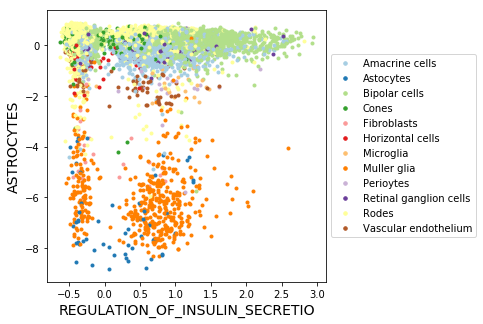

In [201]:
fg = sl.plotFactors(terms=['REGULATION_OF_INSULIN_SECRETIO', 'ASTROCYTES'], X=vars_latent, lab=adata.obs['cell_type'], isCont=False)

In [159]:
fa = h5py.File('FA_corr_no_hidden.hdf5')

In [160]:
all_terms = fa['terms'][()]
select_terms = lambda t1, t2: np.where(np.logical_or(all_terms==t1, all_terms==t2))[0]

In [161]:
terms = select_terms(b'REGULATION_OF_INSULIN_SECRETIO', b'ASTROCYTES')

In [162]:
(fa['Z'][()][:, terms]>0.5).sum(0)

array([14, 82])

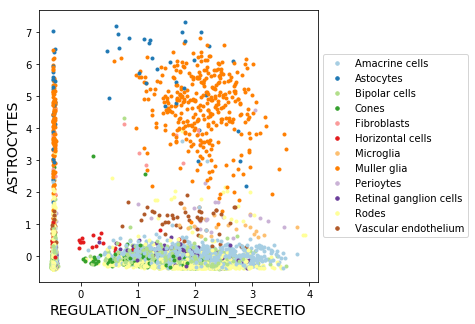

In [163]:
fg = sl.plotFactors(terms=['REGULATION_OF_INSULIN_SECRETIO', 'ASTROCYTES'], X=fa['X'][:, terms], lab=adata.obs['cell_type'], isCont=False)

In [164]:
fa.close()